# forecastframe - a fast and accurate hierarchical timeseries forecasting library for Python

## Introduction

`forecastframe` generates interpretable forecasts 
using best-in-class feature-engineering, modeling, and validation strategies. 
It's designed to abstract away hierarchical relationships (e.g., [[Country -> 
State -> Store], [Category -> Brand -> Product]]) and common time-series issues 
so that you can focus on feature creation, model interpretation, and delivery.

Main Features
-------------
- **Best-in-class feature engineering, modeling, and interpretation algorithms** inspired
    by world-class forecasting competitions and hedge funds.
- **Intuitive, inheritable class design** simplifies complicated operations (e.g., rolling 
    cross-validation without leakage, model ensembling, etc.) without restricting optionality. 
- **Built for speed and scale**, taking advantage of indexers, generators, and distributed 
    frameworks like mxnet and Ray to run quickly and efficiently with minimal out-of-memory errors.

The examples provided in this notebook were created using filtered data from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy). It's intended as a reference for how this library is intended to be used, and will be updated frequently as we add more features.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import os 

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)

import forecastframe as ff

In [3]:
data_path = os.path.join(directory, "forecastframe", "sample_data", "weekly", "small.csv")
data = pd.read_csv(data_path)

### Sample Data

In [4]:
data

,dept_id,cat_id,item_id,state_id,store_id,datetime,sales
0,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2014-01-06,0.0
1,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2014-01-13,0.0
2,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2014-01-20,0.0
3,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2014-01-27,0.0
4,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,2014-02-03,0.0
...,...,...,...,...,...,...,...
1156,FOODS_1,FOODS,FOODS_1_003,WI,WI_1,2016-05-23,0.0
1157,FOODS_1,FOODS,FOODS_1_003,WI,WI_1,2016-05-30,0.0
1158,FOODS_1,FOODS,FOODS_1_003,WI,WI_1,2016-06-06,0.0
1159,FOODS_1,FOODS,FOODS_1_003,WI,WI_1,2016-06-13,0.0


## Initialization

For now, ForecastFrame is built on pandas. In the future, ForecastFrame will also accept mxnet's `NDArray` and Ray's `Dataset` for distributed processing.  

In [9]:
print(ff.ForecastFrame.__doc__)


    Base class for ForecastFrame.

    Parameters
    ----------
    data : pd.DataFrame
        A pandas DataFrame object. Will eventually support Ray and
        mxnet dataframes.
    hierarchy : list of strings
        A list of grouping columns names stored as strings (e.g.,
        ["Store", "State", "SKU", "Category"])
    datetime_column : string
        Your datetime column to use as the primary index of your dataframe
    target : string
        The outcome variable you're trying to predict (e.g., "Sales")
    sample_size : int, default 1000
        The number of rows of data to use in your viewing sample
    


In [11]:
fframe = ff.ForecastFrame(
    data=data, 
    hierarchy=["dept_id", "cat_id", "item_id", "state_id", "store_id"], 
    datetime_column="datetime", 
    target="sales"
    )

## Preprocessing

### Scaling

You can use log_features, standardize_features, and normalize_features to scale any features in your fframe. Note that only the sample (self.sample) is modified when calling preprocessing or feature engineering functions; your actual data self.data remains intact. This two-stage transformation process keeps the feature engineering process quick and transparent, delaying the generation of features until after the train-test split to avoid leakage. 

In [13]:
fframe.log_features(["sales"])
fframe.get_sample()

,dept_id,cat_id,item_id,state_id,store_id,sales,day,day_of_week,weekend_flag,week,month,year,quarter,month_year,quarter_year
datetime,,,,,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,6,0,False,2,1,14,1,14M01,14Q1
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,13,0,False,3,1,14,1,14M01,14Q1
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,20,0,False,4,1,14,1,14M01,14Q1
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,27,0,False,5,1,14,1,14M01,14Q1
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3,0,False,6,2,14,1,14M02,14Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,12,0,False,42,10,15,4,15M10,15Q4
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,19,0,False,43,10,15,4,15M10,15Q4
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,26,0,False,44,10,15,4,15M10,15Q4


### Encodings

Using `encode_categoricals`, we can easily convert `object` and `category` columns to an integer representation. This operation can be undone using `decode_categoricals`. This is a required preprocessing step for some libraries (e.g., XGBoost). Note this this function modifies both self.sample and self.data for consistency.

In [15]:
fframe.encode_categoricals()
fframe.get_sample()

,dept_id,cat_id,item_id,state_id,store_id,sales,day,day_of_week,weekend_flag,week,month,year,quarter,month_year,quarter_year,sales_lag7,sales_lag14
datetime,,,,,,,,,,,,,,,,,
2014-01-06,0,0,0,0,0,0.000000,6,0,False,2,1,14,1,14M01,14Q1,NaN,NaN
2014-01-13,0,0,0,0,0,0.000000,13,0,False,3,1,14,1,14M01,14Q1,0.0,NaN
2014-01-20,0,0,0,0,0,0.000000,20,0,False,4,1,14,1,14M01,14Q1,0.0,0.0
2014-01-27,0,0,0,0,0,0.000000,27,0,False,5,1,14,1,14M01,14Q1,0.0,0.0
2014-02-03,0,0,0,0,0,0.000000,3,0,False,6,2,14,1,14M02,14Q1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,0,0,2,1,1,0.000000,12,0,False,42,10,15,4,15M10,15Q4,0.0,0.0
2015-10-19,0,0,2,1,1,0.000000,19,0,False,43,10,15,4,15M10,15Q4,0.0,0.0
2015-10-26,0,0,2,1,1,0.000000,26,0,False,44,10,15,4,15M10,15Q4,0.0,0.0


In [17]:
fframe.decode_categoricals()
fframe.get_sample()

,dept_id,cat_id,item_id,state_id,store_id,sales,day,day_of_week,weekend_flag,week,month,year,quarter,month_year,quarter_year,sales_lag7,sales_lag14,sales_mean_roll7_lag1,sales_mean_roll14_lag1
datetime,,,,,,,,,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,6,0,False,2,1,14,1,14M01,14Q1,NaN,NaN,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,13,0,False,3,1,14,1,14M01,14Q1,0.0,NaN,0.0,0.000000e+00
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,20,0,False,4,1,14,1,14M01,14Q1,0.0,0.0,0.0,0.000000e+00
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,27,0,False,5,1,14,1,14M01,14Q1,0.0,0.0,0.0,0.000000e+00
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3,0,False,6,2,14,1,14M02,14Q1,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,12,0,False,42,10,15,4,15M10,15Q4,0.0,0.0,0.0,6.661338e-16
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,19,0,False,43,10,15,4,15M10,15Q4,0.0,0.0,0.0,6.661338e-16
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,26,0,False,44,10,15,4,15M10,15Q4,0.0,0.0,0.0,6.661338e-16


## Feature Engineering

### Seasonality





Time-based features are usually quite impactful when working with timeseries data. `calc_datetime_features` allows you to create many different time features using a single method.

In [19]:
fframe.calc_datetime_features(
    datetime_list = [
        "day",
        "day_of_week",
        "weekend_flag",
        "week",
        "month",
        "year",
        "quarter",
        "month_year",
        "quarter_year",
    ],
)
fframe.get_sample()

,dept_id,cat_id,item_id,state_id,store_id,sales,day,day_of_week,weekend_flag,week,...,quarter_year,sales_lag7,sales_lag14,sales_mean_roll7_lag1,sales_mean_roll14_lag1,sales_max_by_category_roll364_lag1,sales_min_by_category_roll364_lag1,sales_std_by_category_roll364_lag1,sales_mean_by_category_roll364_lag1,sales_median_by_category_roll364_lag1
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,6,0,False,2,...,14Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,13,0,False,3,...,14Q1,0.0,NaN,0.0,0.000000e+00,3.688879,3.688879,NaN,3.688879,3.688879
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,20,0,False,4,...,14Q1,0.0,0.0,0.0,0.000000e+00,3.688879,3.688879,0.000000,3.688879,3.688879
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,27,0,False,5,...,14Q1,0.0,0.0,0.0,0.000000e+00,4.941642,3.688879,0.723283,4.106467,3.688879
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3,0,False,6,...,14Q1,0.0,0.0,0.0,0.000000e+00,4.941642,3.688879,0.593472,4.077096,3.838932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,12,0,False,42,...,15Q4,0.0,0.0,0.0,6.661338e-16,14.046394,7.677864,1.532169,10.901727,11.211665
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,19,0,False,43,...,15Q4,0.0,0.0,0.0,6.661338e-16,14.046394,7.677864,1.527899,10.843093,11.149925
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,26,0,False,44,...,15Q4,0.0,0.0,0.0,6.661338e-16,14.046394,7.677864,1.519703,10.779012,11.115429


### Statistical Features

#### Lagged (shifted) features

When working with retail data, we'll often want to lag our target variable to see how much it sold one week ago, two weeks ago, four weeks ago, etc. Using `lag_features`, we can create two new columns describing what sales were like both one week (7 days) and two weeks ago.  When picking your `lags` argument, think in terms of numbers of days (hence the 7 and 14, below).

In [21]:
def display_new_columns(number_of_columns, data):
    """
    Displays the hierarchy columns at the beginning of our dataset and the new columns at the end, hiding               previously-created columns for clarity. Used for clarity throughout this demonstration.
    """

    display(data.iloc[:, list(range(6)) + list(range(-number_of_columns, -0))])

fframe.lag_features(features=["sales"], lags=[7, 14])
display_new_columns(2, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,sales_lag7,sales_lag14
datetime,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,NaN
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.0
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.0
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,0.0
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,0.0
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,0.0


### Rolling, shifted aggregations with momentums

We can use `calc_statistical_features` to create all kinds of interesting statistical features. This function combines several important processes together to create useful features:

- Groups your data to a level above your chosen hierarchy if `groupers` is specified
- Rolls your data according to `windows`, which is always measured in days. Note that you can pass as many windows as you'd like via a list or tuple.
- Calculates new statistical features based on the arguments you pass to `aggregations`
- Lags your newly-created features based on `lag` to avoid leaking information during training. By default, this function shifts your data back by one day. 

This function is very flexible, so we'll walk through some detailed examples of its recommended use.

#### Rolling one-week and two-week averages

For our first example, we calculate the rolling one and two week averages for our target features, `sales`.

In [23]:
fframe.calc_statistical_features(features=["sales"], windows=[7, 14], lag=1, aggregations="mean")
display_new_columns(2, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,sales_mean_roll7_lag1,sales_mean_roll14_lag1
datetime,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.000000e+00
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.000000e+00
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.000000e+00
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,6.661338e-16
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,6.661338e-16
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.0,6.661338e-16


#### Rolling statistical measures for the past year of sales at the category level

Sometimes, we want to include statistical features at an aggregated level
    (e.g., at the categry level). This is possible using the `groupers` argument.
    Here, we get the sum of sales in our store over the past day and the past week, then
    calculate what percentage of the total each row accounted for. Note that we're
    implicitly lagging our dataframe by 1 period to avoid leaking information to our
    classifier. We aren't specifiying `aggregations` here, so our function will return the mean, max, min, median, and standard deviation by default. 

One note aboug aggregating features: `groupers` requires you to specify the desired `name`, `operation`, and `columns` in a dictionary to help the aggregation operation understand how your target feature should be rolled-up. In the example below, we're telling our forecastframe to aggregate our target variable (`sales`) by `cat_id` by summing the values before calculating the desired statistical features (e.g., `sales_media_by_category_roll364_lag1`).

In [25]:

fframe.calc_statistical_features(
    features=["sales"], 
    windows=[364], 
    lag=1, 
    groupers={
        "name":"by_category", 
        "operation": "sum", 
        "columns":["cat_id"]
        }
    )

display_new_columns(5, fframe.get_sample())


,dept_id,cat_id,item_id,state_id,store_id,sales,sales_max_by_category_roll364_lag1,sales_min_by_category_roll364_lag1,sales_std_by_category_roll364_lag1,sales_mean_by_category_roll364_lag1,sales_median_by_category_roll364_lag1
datetime,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN,NaN,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3.688879,3.688879,NaN,3.688879,3.688879
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3.688879,3.688879,0.000000,3.688879,3.688879
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,4.941642,3.688879,0.723283,4.106467,3.688879
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,4.941642,3.688879,0.593472,4.077096,3.838932
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,14.046394,7.677864,1.532169,10.901727,11.211665
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,14.046394,7.677864,1.527899,10.843093,11.149925
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,14.046394,7.677864,1.519703,10.779012,11.115429


#### Rolling mean, sum, and skew of sales for the past month with additional momentum and percentage features

In this last example, we add additional features describing the mometum and rolling percentage for our calculated features. We can interpret these additional features as:

- **sales_mean_roll28_lag1_momentum**: How different was last week's sales compared to the rolling average for the previous month? Taking 2011-02-14 as an example, a value of 1.248393 suggests that the previous week's sales were 24.8393% higher than the rolling average over the past month (a coefficient of 1.248393).
- **sales_sum_roll28_lag1_perc**: What percent of sales over the past month were attributed to the previous week? Taking 2011-02-14 as an example, a value of .624196 suggests that the previous week's sales acocunt for 62.42% of the previous month's sales (note that, up to this point, there were only two days of sales to compare against, hence the larget percentage). 

Again, we lag these features by one period by default to avoid leaking information during training.



In [27]:

fframe.calc_statistical_features(
    features=["sales"], 
    windows=[28],
    aggregations= ["mean", "sum", "skew"],
    momentums=True,
    percentages=True
    )

display_new_columns(5, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,sales_perc_greater0_roll28_lag1,sales_perc_greater0_roll84_lag1,sales_mean_roll28_lag1,sales_sum_roll28_lag1,sales_skew_roll28_lag1
datetime,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN,NaN,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000,0.000000e+00,0.000000e+00,NaN
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000,0.000000e+00,0.000000e+00,NaN
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000,0.000000e+00,0.000000e+00,NaN
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000,0.000000e+00,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.25,0.666667,4.023595e-01,1.609438e+00,2.0
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.25,0.583333,4.023595e-01,1.609438e+00,2.0
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.00,0.500000,2.220446e-16,8.881784e-16,NaN


#### Sum of department sales week-over-week

Finally, this function is flexible enough to aggregate your target variable to different levels of your hierarchy. In the example below, we aggregate `sales` within each department, lag it by one week to avoid leakage, and assign it to `sales_sum_by_department_roll7_lag1`.

In [29]:
fframe.calc_statistical_features(
    features=["sales"], 
    windows=[7],
    aggregations= ["sum"],
    groupers={
        "name":"by_department", 
        "operation": "sum", 
        "columns":["dept_id"]
        }
    )

display_new_columns(1, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,sales_sum_by_department_roll7_lag1
datetime,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3.688879
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3.688879
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,4.941642
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,3.988984
...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,11.115429
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,9.457200
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,9.336092


### Exponential Moving Averages With Crossovers

Exponetial moving averages are similar to normal moving averages, but
they weigh recent values more heavily than older observations. Due to issues with
pandas' `ewm` function, we write our windows here in terms of relative periods,
not days. In the example below, we calculate the two-week exponential moving average of sales. We also include an additional `crossover` column, which compares ratios of moving averages to understand when the shorter, more responsive moving average "crosses-over" the slower, more stable moving average.

In [31]:
fframe.calc_ewma(
    features=["sales"],
    windows=[14, 28],
    crossovers=True
)
display_new_columns(2, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,sales_ewma_roll14_lag1,sales_ewma_roll28_lag1
datetime,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.768502,0.902529
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.666035,0.840205
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.577230,0.782189


### Percent of Observations vs. Threshold

In timeseries forecasting, we're often interested in patterns that hold over long periods of time. The `calc_percent_relative_to_threshold` function enables us to calculate what percent of observations meet a given threshold over one or more rolling windows. In the example below, we calculate the percent of days with sales greater than zero both in the past month (28 days) and past three months



In [33]:
    fframe.calc_percent_relative_to_threshold(windows=[28, 28*3], threshold=0)
    display_new_columns(2, fframe.get_sample())


,dept_id,cat_id,item_id,state_id,store_id,sales,sales_perc_greater0_roll28_lag1,sales_perc_greater0_roll84_lag1
datetime,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,NaN,NaN
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...
2015-10-12,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.25,0.666667
2015-10-19,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.25,0.583333
2015-10-26,FOODS_1,FOODS,FOODS_1_003,TX,TX_1,0.000000,0.00,0.500000


### Percent Change

This function enables you to calculate the period-over-period percent change at different levels of your hierarchy. As usual, we lag one period by default to avoid information leakage during training.

#### Percent change at the current level of the hierarchy

The `sales_pct_change` column below can be interpreted as the percent change in sales from last week compared to two weeks ago.

In [35]:
fframe.calc_percent_change(feature="sales")
display_new_columns(1, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,multiracial_perc
datetime,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
...,...,...,...,...,...,...,...
2016-05-23,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-05-30,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-06-06,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4


#### Percent change in category sales

The example below is similiar to the one above, but now we're calculating how the overall sales for the category changed last week relative to two weeks ago. Similiar to when using `calc_statistical_features`, we pass `groupers` a dictionary that specifies what we want to call this subset of columns. This naming convention helps avoid unruly feature names when aggregating over multiple columns.

In [37]:
fframe.calc_percent_change(
    feature="sales", 
    groupers={
        "name": "by_category",
        "columns":["cat_id"]
    }
)

display_new_columns(1, fframe.get_sample())

,dept_id,cat_id,item_id,state_id,store_id,sales,multiracial_perc
datetime,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
...,...,...,...,...,...,...,...
2016-05-23,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-05-30,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-06-06,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4


### Retail Features

#### Days since first purchase or release

If `ignore_leading_zeroes` is set to True, the feature will count the number of days since a product's first sale. If false, this feature counts the days since the product first appeared in the dataset.



In [39]:
fframe.calc_days_since_release(ignore_leading_zeroes=True)
display_new_columns(1, fframe.get_sample())


,dept_id,cat_id,item_id,state_id,store_id,sales,multiracial_perc
datetime,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,4.9
...,...,...,...,...,...,...,...
2016-05-23,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-05-30,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4
2016-06-06,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,2.4


## External Features

#### Demographics

`forecastframe` enables you to create external features using publicly available APIs. In the example below, we add numerous demographic features to our dataframe using `join_demographics`. 

In [ ]:
fframe.join_demographics( year=2019, joiner="state_id", level="state")
display_new_columns(8, fframe.get_sample())

## Modeling

Now that we're finished with feature engineering, let's take a look at what our final modeling dataframe will look like. Again, only the sample has been updated to this point, not our actual data. When we run `cross_validate_model`, it will automatically create all the features we requested without leaking data to our test set.

In [36]:
fframe.get_sample()

,dept_id,cat_id,item_id,state_id,store_id,sales,day,day_of_week,weekend_flag,week,...,below_povery_line_perc,labor_force_perc,african_american_perc,caucasian_perc,american_indian_alaskan_perc,asian_perc,indian_perc,hispanic_perc,other_race_perc,multiracial_perc
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-06,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,6,0,False,2,...,9.6,63.7,5.8,59.7,0.8,14.5,2.0,39.0,14.0,4.9
2014-01-13,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,13,0,False,3,...,9.6,63.7,5.8,59.7,0.8,14.5,2.0,39.0,14.0,4.9
2014-01-20,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,20,0,False,4,...,9.6,63.7,5.8,59.7,0.8,14.5,2.0,39.0,14.0,4.9
2014-01-27,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,27,0,False,5,...,9.6,63.7,5.8,59.7,0.8,14.5,2.0,39.0,14.0,4.9
2014-02-03,FOODS_1,FOODS,FOODS_1_001,CA,CA_1,0.0,3,0,False,6,...,9.6,63.7,5.8,59.7,0.8,14.5,2.0,39.0,14.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-23,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,23,0,False,22,...,7.2,66.5,6.4,85.4,0.9,2.8,0.6,6.8,2.0,2.4
2016-05-30,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,30,0,False,23,...,7.2,66.5,6.4,85.4,0.9,2.8,0.6,6.8,2.0,2.4
2016-06-06,FOODS_1,FOODS,FOODS_1_002,WI,WI_1,0.0,6,0,False,24,...,7.2,66.5,6.4,85.4,0.9,2.8,0.6,6.8,2.0,2.4


Looking good! From here, the actual modeling process is quite easy. It relies on one function, `cross_validate_model()` to do the heavy lifting.

`cross_validate_model()` incorporates best-in-class modeling and validation strategies into a single function while avoiding data leakage and other issues that tend to arise in complicated modeling pipelines. At a high-level, this function:

- Splits your data into rolling folds using sklearn's `TimeSeriesSplit`
- For each fold:
    - Split data into training and test sets
    - Scale your training and test sets separately to avoid data leakage
    - Mask your test actuals to avoid leakage during feature engineering
    - Concatenate your train and test sets to generate all of your requested features, then split them apart again 
    - Fit your model using the algorithm you passed to the `estimator_func` argument of `cross_validate_model` and generate predictions
    - Descale your predictions and actuals
    - Store your predictions, actuals, inputs, and parameters into the `result` attribute of your `fframe` for further use
    
For all of the options you can pass to this function, see the docs by typing `?fframe.cross_validate_model`. Listed below, you'll find a few example configurations for how you might want to run this function.


#### Parameter tuning with RandomizedSearchCV

RandomizedSearch is usually much faster than GridSearch and may help to avoid overfitting. Use `n_iter` to control how many iterations you search over your parameter space. Note that `RandomizedSearchCV` is the default value for `cv_func`, but we import it below for demonstrative purposes.

In [38]:
from sklearn.model_selection import RandomizedSearchCV

params = ff.get_lgb_params("light") # generate a pre-made set of LightGBM params

fframe.save_fframe("PRE-MODEL.pkl")
fframe.cross_validate_model(
    params=params,
    estimator_func=ff._get_regression_lgbm, # use LightGBM's default regressor
    cv_func=RandomizedSearchCV,
    n_iter=10
)

fframe.save_fframe("POST-MODEL.pkl")

#### Tweedie regression with GridSearchCV tuning

In the example below, we run a full gridsearch over our parameter space using GridSearchCV.

In [40]:
from sklearn.model_selection import GridSearchCV

fframe.cross_validate_model(
    split_period="year",
    params=params,
    estimator_func=ff._get_tweedie_lgbm, # use LightGBM's Tweedie regression setting
    cv_func=GridSearchCV
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-08f47a2bfb84>", line 7, in <module>
    cv_func=GridSearchCV
  File "c:\Users\nthor\OneDrive\Documents\GitHub\forecastframe\forecastframe\model.py", line 470, in cross_validate_model
    scoring=scoring,
  File "c:\Users\nthor\OneDrive\Documents\GitHub\forecastframe\forecastframe\model.py", line 163, in _calc_best_estimator
    cv_object.fit(X, y, groups=time_grouper)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "C:\ProgramDat

TypeError: object of type 'NoneType' has no len()

#### Quantile regression with RandomizedSearchCV tuning

Finally, we fit a quantile regressor to our sample data. By default, this estimator produces 50% quantile (median) predictions

In [25]:
fframe.cross_validate_model(
    split_period="year",
    params=params,
    estimator_func=ff._get_quantile_lgbm,
    n_iter=10
)

## Interpretation & Validation

By calling `cross_validate_`model, we've now created a nested dictionary attribute called `results` which houses all of the useful information we'll need to evaluate our model fits. The first layer of the dictionary is split by fold, while the second layer stores important data for each fold.

In [4]:
fframe = ff.load_fframe("POST-MODEL.pkl")
print(f"First layer: {fframe.results.keys()}")
print(f"Second layer: {fframe.results[0].keys()}")

First layer: dict_keys([0, 1, 2, 3, 4])
Second layer: dict_keys(['best_estimator', 'OOS_predictions', 'OOS_actuals', 'OOS_input', 'IS_predictions', 'IS_actuals', 'IS_input', 'best_IS_error', 'best_OOS_error', 'best_params'])


### Results Over Time

We can plot our results over time using the `plot_predictions_over_time` method, which returns both an in-sample and out-of-sample figure in a dictionary.


In [52]:
import altair as alt
# necessary argument for larger datasets to avoid altair limitations; will update in a future version
alt.data_transformers.disable_max_rows()

figs = fframe.plot_predictions_over_time()
figs["IS"]

alt.Chart(...)

In [53]:
figs["OOS"]

alt.Chart(...)

### Calculating Error Metrics

First, we run .process_outputs() to create a dataframe of predictions and actuals for visualization. This step is optional (it will be called automatically by later functions if not invoked), but enables you to aggregate your predictions and actuals by different levels of the hierarchy using the `grouper` argument

In [54]:
fframe.process_outputs()

To calculate error metrics for a particular fold, we can pass a `fold` argument to `calc_error_metrics`. To calculate error metrics for all folds, we can run `calc_all_error_metrics`. `calc_error_metrics` returns a DataFrame, while `calc_all_error_metrics` stores the error metrics in the fframe's `fold_errors` attribute. 

To get error metrics for a given fold, use `fframe.fold_errors[{your fold integer here}]`. The example below gets the errors for the fifth fold (zero-indexed, hence passing '4' as the key). The NaN values in the out-of-sample columns represent in-sample-only observations.

In [58]:
fframe.calc_all_error_metrics()
fframe.fold_errors[4]

,In-Sample Actuals,In-Sample Predictions,In-Sample AE,In-Sample APE,In-Sample SE,Out-of-Sample Actuals,Out-of-Sample Predictions,Out-of-Sample AE,Out-of-Sample APE,Out-of-Sample SE
0,0.0,0.202125,0.202125,NaN,0.040855,7.000000,4.509278,2.490722,0.355817,6.203694
1,0.0,0.343582,0.343582,NaN,0.118048,10.000001,5.176830,4.823171,0.482317,23.262981
2,0.0,0.064655,0.064655,NaN,0.004180,5.000000,5.249842,0.249842,0.049968,0.062421
3,0.0,-0.002014,0.002014,NaN,0.000004,4.000000,4.618956,0.618956,0.154739,0.383106
4,0.0,0.235034,0.235034,NaN,0.055241,2.000000,3.995132,1.995132,0.997566,3.980553
...,...,...,...,...,...,...,...,...,...,...
963,0.0,0.346836,0.346836,NaN,0.120295,NaN,NaN,NaN,NaN,NaN
964,0.0,0.632867,0.632867,NaN,0.400521,NaN,NaN,NaN,NaN,NaN
965,0.0,0.437949,0.437949,NaN,0.191800,NaN,NaN,NaN,NaN,NaN
966,0.0,0.202760,0.202760,NaN,0.041112,NaN,NaN,NaN,NaN,NaN


We can plot the distribution of a particular error metric by fold using `plot_fold_distributions`. By default, this function plots the distribution of RMSE by fold. We used altair as our visualization library to enable handle tooltip options, which should be demonstrable in the embedded HTML below.

In [60]:
fframe.plot_fold_distributions(error_type="APE")

alt.Chart(...)

### Summarizing Error Metrics

We can also summarize the findings of our cross-validation with a few simple methods.

In [5]:
fframe.summarize_fit()

**Performance**: For our last fold, our model achieved a median 24.18% in-sample absolute percent error and 44.98% out-of-sample absolute percent error. On a weighted average basis, our model achieved a 27.80% in-sample error and a 50.44% out-of-sample error. The difference between our out-of-sample median and weighted average values suggests that our model is more accurate when predicting smaller values. 
 
 **Fit**: The 20.81% error differential between our out-of-sample and in-sample results suggests that our model is significantly overfitting our training data. Given your poor out-of-sample performance and the significant difference between your in-sample and out-of-sample results, we would recommend making drastic improvements to your approach to control for underfitting. Here are a few tips to control for overfitting: 
 - Add more training data and/or resample your existing data 
 - Add new features or modifying existing features based on insights from feature importance analysis 
 - Reduce or eliminate regularization (e.g., decrease lambda, reduce dropout, etc.)

In [6]:
fframe.summarize_performance_over_time()

Performance: Our out-of-sample APE was nan in the prior month, compared to an average error of 44.46% over the past three months.

Trends: Sales fell by -1.0 last month, down -1.0 over the previous year. We expect sales to continue trending upwards in the coming month.

## SHAP Values

Finally, we can plot and summarize our model's SHAP values to help understand the underlying relationships between our covariates. We start by calculating our SHAP values, where we specify our fold (defaults to the last fold) and sample (defaults to out-of-sample).

In [6]:
fframe.calc_shap_values()

After calculating our SHAP values once, they can be used in a variety of summary and plotting functions.

In [16]:
fframe.summarize_shap()

**Demand Drivers**: The most important features in this last run were sales_ewma_roll14_lag1, sales_ewma_roll28_lag1, sales_sum_roll28_lag1, and sales_mean_roll28_lag1_momentum, accounting for 54.65% of the variability in our SHAP values. The least important features were asian_perc, indian_perc, hispanic_perc, and dept_id, accounting for approximately 0.00% of our SHAP's variance.

**Statistical Features**: Statistical features make up 5 of the top 10 features, contributing 57.17% of this week's predicted values. Given the importance of statistical features in this last run, you may consider adding additional rolling funtions (e.g., skew, kurtosis) and/or window periods to your feature set for future runs.

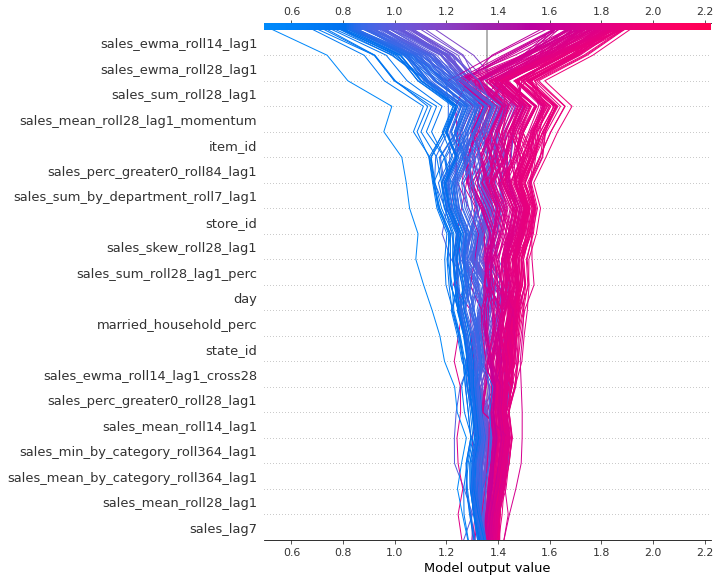

In [8]:
fframe.plot_shap_decision()

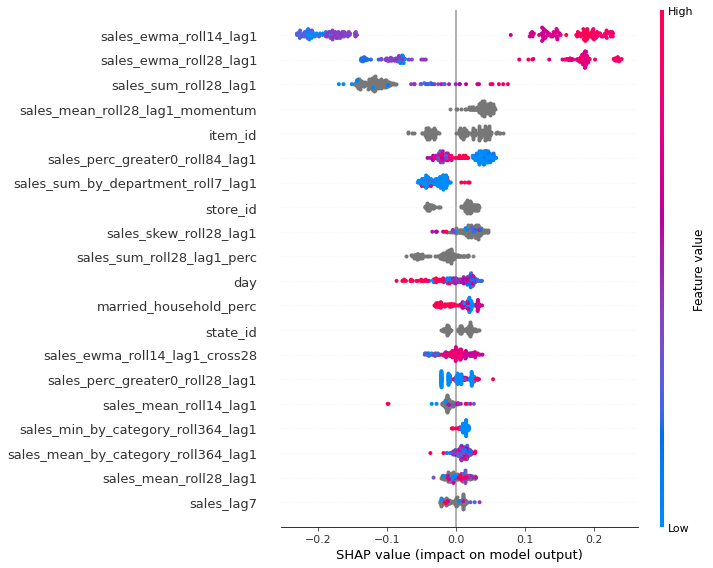

In [40]:
fframe.plot_shap_importance()

Note that you can modify any plot using *args and **kwargs.

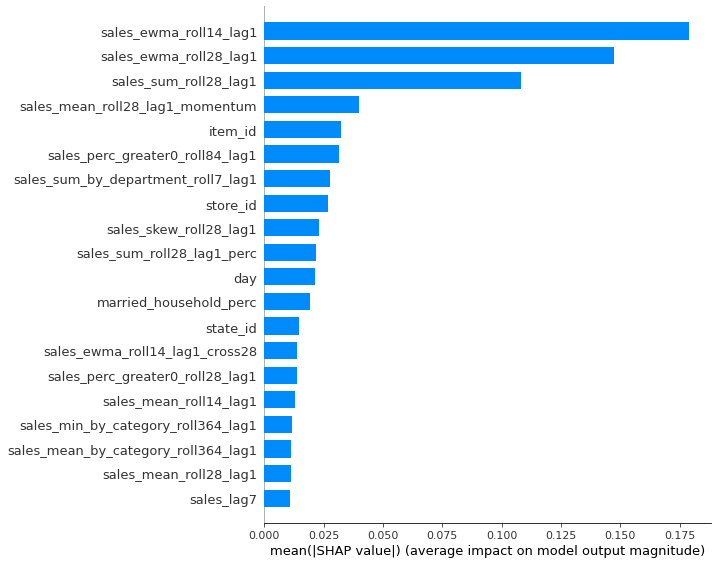

In [39]:
fframe.plot_shap_importance(plot_type="bar")

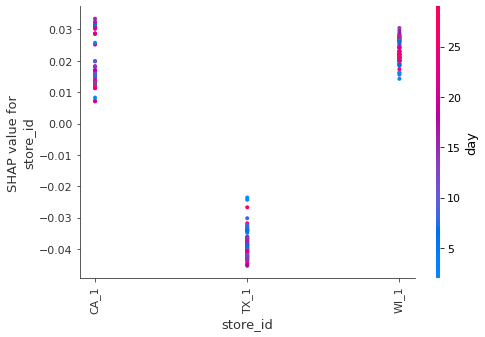

In [29]:
fframe.plot_shap_dependence(column_name="store_id", color_column="day")

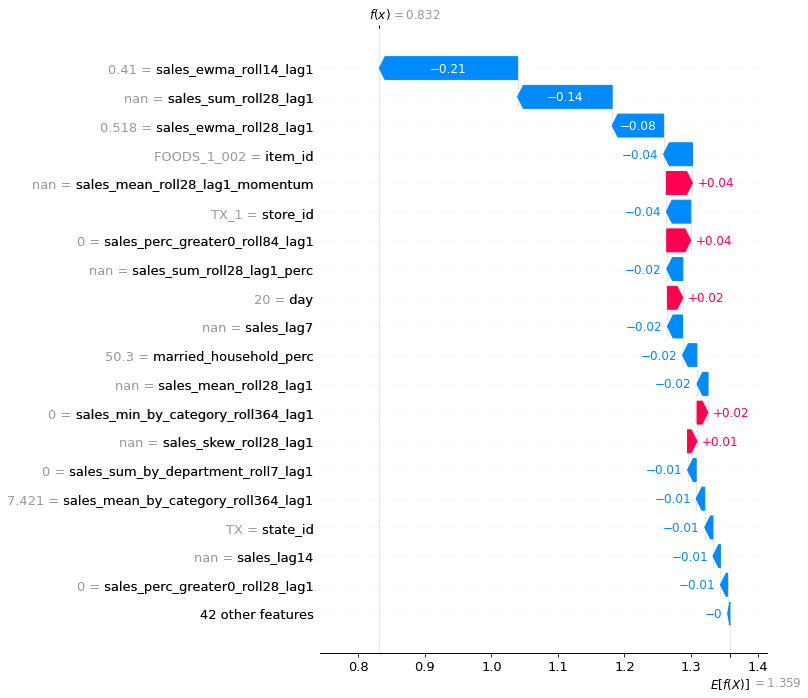

In [22]:
fframe.plot_shap_waterfall(row=192, max_display=20)

In [34]:
fframe.plot_shap_force()

In [35]:
fframe.plot_shap_force(slicer=0) # create force plot for only first row

## Utilities

### Filling

You can easily fill gaps in time with new rows, then fill the nulls using data from nearby days. Note that, if we wanted to, we could fill the nulls by passing `method="bfill"` as a keyword argument to fill_time_gaps().

In [8]:
fframe.fill_time_gaps()
display(fframe) # Notice how every day now has its own row

            dept_id cat_id      item_id state_id store_id     sales   day  \
datetime                                                                    
2011-01-31  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  1.386294  31.0   
2011-02-01  FOODS_1  FOODS  FOODS_1_001       CA     CA_1       NaN   NaN   
2011-02-02  FOODS_1  FOODS  FOODS_1_001       CA     CA_1       NaN   NaN   
2011-02-03  FOODS_1  FOODS  FOODS_1_001       CA     CA_1       NaN   NaN   
2011-02-04  FOODS_1  FOODS  FOODS_1_001       CA     CA_1       NaN   NaN   
...             ...    ...          ...      ...      ...       ...   ...   
2016-03-24  FOODS_1  FOODS  FOODS_1_219       CA     CA_1       NaN   NaN   
2016-03-25  FOODS_1  FOODS  FOODS_1_219       CA     CA_1       NaN   NaN   
2016-03-26  FOODS_1  FOODS  FOODS_1_219       CA     CA_1       NaN   NaN   
2016-03-27  FOODS_1  FOODS  FOODS_1_219       CA     CA_1       NaN   NaN   
2016-03-28  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508  28.0   

If we need to fill any missings in our dataframe, we can forward fill (ffill) and backward fill (bfill) them using `fill_missings`.

In [9]:
fframe.fill_missings(method="bfill", features=["sales"])
display(fframe)

            dept_id cat_id      item_id state_id store_id     sales   day  \
datetime                                                                    
2011-01-31  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  1.386294  31.0   
2011-02-01  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  2.302585   NaN   
2011-02-02  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  2.302585   NaN   
2011-02-03  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  2.302585   NaN   
2011-02-04  FOODS_1  FOODS  FOODS_1_001       CA     CA_1  2.302585   NaN   
...             ...    ...          ...      ...      ...       ...   ...   
2016-03-24  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508   NaN   
2016-03-25  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508   NaN   
2016-03-26  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508   NaN   
2016-03-27  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508   NaN   
2016-03-28  FOODS_1  FOODS  FOODS_1_219       CA     CA_1  3.496508  28.0   